In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.python.framework import ops
import pickle
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
#from cnn_utils import *

import pandas as pd
import os

c:\users\shantanu\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#load dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        #one hot encoding in pandas best method till now
        x=pd.Series(dict[b'labels']) 
        labels=pd.get_dummies(x)
        labels=np.array(labels)
    return (dict[b'data'].reshape(10000,32,32,3),labels)
X_train,Y_train=unpickle("cifar-10-batches-py/data_batch_1")
X_test,Y_test=unpickle("cifar-10-batches-py/test_batch")


In [4]:
#defenition
def place_hold(n_H0, n_W0, n_C0, n_y):#height width,depth(channel),no of Classes
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X,Y
    

In [5]:
X,Y=place_hold(32,32,3,10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 32, 32, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [6]:
#shape of input = [batch, in_height, in_width, in_channels]
 #  shape of filter = [filter_height, filter_width, in_channels, out_channels]
def filter_weights():
    W1 = tf.get_variable("W1",[5,5,3,6],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[5,5,6,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable("W3",[5,5,16,128],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3":W3}
    return parameters

In [7]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    Z3 = tf.nn.conv2d(P2,W3, strides = [1,1,1,1], padding = 'SAME')
    A3 = tf.nn.relu(Z3)
    P3 = tf.nn.max_pool(A3, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    P3 = tf.contrib.layers.flatten(P3)
    Z4 = tf.contrib.layers.fully_connected(P3, 10,activation_fn=None)
    return Z4

In [8]:
def compute_cost(Z4, Y):
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z4,labels = Y)
    cost = tf.reduce_mean(cost)
    return cost

In [9]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.000001,
          num_epochs = 100, minibatch_size =10000, print_cost = True):
  
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                           
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = 10,32,32,3        
    n_y = Y_train.shape[1]                           
    costs = []                                        
    X, Y = place_hold(n_H0,n_W0,n_C0,n_y)
    parameters =  filter_weights()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            minibatch_cost = 0.     
            for i in (0,9999):
                (minibatch_X, minibatch_Y) = X_train[i].reshape(1,32,32,3),Y_train[i].reshape(1,10)
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost   
            print("epochs"+str(epoch),minibatch_cost)
        plt.plot(np.squeeze(minibatch_cost))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

epochs0 45.446688652038574
epochs1 34.25781726837158
epochs2 23.50455093383789
epochs3 14.713554680347443
epochs4 12.727615032345057
epochs5 11.290761485695839
epochs6 10.097166776657104
epochs7 9.604262351989746
epochs8 9.200508117675781
epochs9 8.827279806137085
epochs10 8.467315912246704
epochs11 8.107194423675537
epochs12 7.734713315963745
epochs13 7.343144655227661
epochs14 6.936070919036865
epochs15 6.526094675064087
epochs16 6.127051830291748
epochs17 5.751762866973877
epochs18 5.414862632751465
epochs19 5.1292887926101685
epochs20 4.9009997844696045
epochs21 4.716057300567627
epochs22 4.541029095649719
epochs23 4.3433767557144165
epochs24 4.111666440963745
epochs25 3.8556156158447266
epochs26 3.590855598449707
epochs27 3

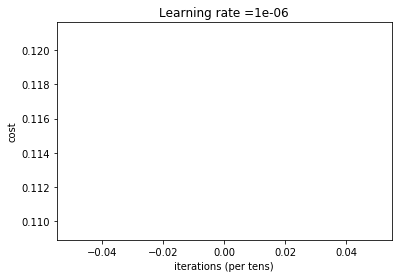

Tensor("Mean_1:0", shape=(), dtype=float32)


In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)